In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10, MNIST
from torchvision.models import resnet18
import torchvision.transforms.v2 as transforms

device = torch.device('cuda')

# What does the softmax "layer" do?

When we train a model on classification we use a linear output layer followed by a softmax activation to scale the outputs of the linear layer. In this notebook we'll take a closer look at what this layer actually learn when using a softmax output.



### Setting up the dataset
We start by setting up the data. We will use MNIST as is the tradition in deep learning for imaging.

In [2]:
class ExpandChannels(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.num_channels = num_channels
    
    def forward(self, img):
        # Count channels from back, so we can use it both for single examples and batches
        *leading_dims, n_channels, height, width = img.shape
        if n_channels != self.num_channels:
            repeats = [1 for d in leading_dims] + [self.num_channels, 1, 1]
            new_img = img.repeat(*repeats)
        else:
            new_img = img
        return new_img
        
    

dataset_transforms = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True), ExpandChannels(3)])
train_dataset = MNIST(root='../datasets', download=True, transform=dataset_transforms)
test_dataset = MNIST(root='../datasets', train=False, download=True, transform=dataset_transforms)
num_classes = len(train_dataset.classes)

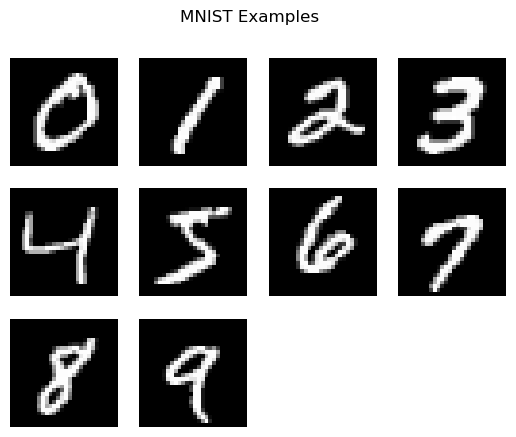

In [102]:
# Let's look at some examples. We take the first unique images of each class
unique_targets, target_indices = np.unique(train_dataset.targets, return_index=True)
fig, axises = plt.subplots(3,4)
for ax in axises.flatten():
    ax.set_axis_off()
for target_index, ax in zip(target_indices, axises.flatten()):
    tensor_image, label = train_dataset[target_index]
    # torchvision images are channel-first, we transpose 
    # it so channel is last and convert it to a numpy array
    numpy_image = tensor_image.permute(1, 2, 0).numpy()
    ax.imshow(numpy_image)
fig.suptitle("MNIST Examples")
plt.show()

In [88]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 5)

In [3]:
from sklearn.model_selection import train_test_split
train_indices, dev_indices = train_test_split(np.arange(len(train_dataset)),  test_size=0.1, random_state=42, stratify=train_dataset.targets)


In [4]:
train_images, train_targets = zip(*[train_dataset[i] for i in train_indices])
dev_images, dev_targets = zip(*[train_dataset[i] for i in dev_indices])



In [5]:
train_images = torch.stack(train_images)
train_targets = torch.tensor(train_targets)
dev_images = torch.stack(dev_images)
dev_targets = torch.tensor(dev_targets)

In [6]:
from torch.utils.data import TensorDataset
train_split_dataset = TensorDataset(train_images, train_targets)
dev_split_dataset = TensorDataset(dev_images, dev_targets)

### The visualization subset

To illustrate what the model learns, we'll select a subset of the training data to use to calculate features. The reason for selecting a subset of the training data is for us to understand what the model is actually doing while it's learning.

In [7]:
# Well make a small subselection of the training samples
n = 20
visualization_sample_index, _ = train_test_split(np.arange(len(train_images)), shuffle=True, stratify=train_targets, train_size=n*num_classes)
visualization_images = torch.stack([train_images[i] for i in visualization_sample_index])
visualization_targets = torch.stack([train_targets[i] for i in visualization_sample_index])
visualization_dataset = TensorDataset(visualization_images, visualization_targets)


## The model
We'll create a simple resnet-based model and focus on the layers just before applying the softmax function. We replace the pre-defined fully connected layers with a single two-part bottleneck. We select the dimensionality of this bottleneck such that we can visualize it (e.g. 2D or 3D). In the first case we will make things neat by forcing the model to use unit-norm vectors for the bottleneck representations as well as the output weights. This means that the only thing the network can change to change the prediction output is the angle between the bottleneck representations and the output weights.

In [12]:
from torch.nn.functional import normalize

model = resnet18(weights=None)

# Determine the number of input features to the output layer:
num_ftrs = model.fc.in_features

# We will create an "prediction head" which will actually be two linear layers with a bottlneck inbetween. 
# The linear layers will be bottlenecked through a 2D feature space so that they live in a geometric space 
# we can visualize. We make this into a class because we want to easily manipulate the intermediate results

class SphericalPredictionHead(nn.Module):
    def __init__(self, input_dimension, output_dimension, bottleneck_dimension=2, rng=None):
        super().__init__()
        if rng is None:
            rng = np.random.default_rng()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.bottleneck_dimension = bottleneck_dimension
        
        # Since we actually only want linear transformations, which we're going to normalize before 
        # using, it's easier to just create the matrices explicitly. Note that we will multiply 
        # these matrices from the right since we assume that the first axis of the input is the 
        # batch dimension.
        self.input_transform = nn.Parameter(torch.tensor(rng.normal(size=(input_dimension, bottleneck_dimension)), dtype=torch.float32))
        self.output_transform = nn.Parameter(torch.tensor(rng.normal(size=(bottleneck_dimension, output_dimension)), dtype=torch.float32))
    
    def forward(self, x):
        x_reduced = torch.matmul(x, self.input_transform)
        x_normalized = normalize(x_reduced, dim=-1) # By using -1, we're saying that the normalization should be along the innermost axis.
        output_transform_normalized = normalize(self.output_transform, dim=0)
        # We're now taking the matrix multiplication between the normalized input vectors (all lying on the unit sphere) with the 
        # normalized "softmax" weights, also lying on the unit sphere. This is exactly the same as calculating the cosine of 
        # the angle between the vectors
        cosines = torch.matmul(x_normalized, output_transform_normalized)
        return cosines

rng = np.random.default_rng(1729)
prediction_head = SphericalPredictionHead(num_ftrs, num_classes, bottleneck_dimension=2, rng=rng)
model.fc = prediction_head
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Getting the feature representations

What we're really interested in is getting the representations of our images just before we send them to the classification layer. This is how the neural network has learnt to represent the images to minimize the categorical cross entropy. We also want the normalized weights so that we can visualize them. The torchvision package has neat utilities for doing this. We can use the function `get_graph_node_names`to trace the compute graph of the model it can create a tree of nodes which are being called. This returns two lists of node names: one for the model in _training_ mode and one in _evaluation_ mode. In this case we're going to use the model in evaluation mode to get the representations, so the nodes we are interested in are in the second of the two returned lists:

In [13]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
# Inspect the forward graph of our model to get the correct feature node
train_nodes, eval_nodes = get_graph_node_names(model)
eval_nodes

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.add',
 'layer1.0.relu_1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.add',
 'layer1.1.relu_1',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_1',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.add',
 'layer2.1.relu_1',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample.0',
 'layer3.0.downsample.1',
 'layer3.0.add',
 'layer3.0.relu_1',
 'layer3.1.conv1',
 'layer3.1.bn1',
 'layer3.1.relu',
 'layer3.1.conv2',
 'layer3.1.bn2',
 'layer3.1.add',
 'layer3.1.relu_1',
 'layer4.0.conv1',
 'layer4.0.bn1',
 'layer4.0.relu',
 'layer4.0.conv2',
 'layer4.0.bn2',

Here you can see that there are a couple of nodes whos names start with `fc.`, you might recognize them from our SphericalPredictionHead. The first `fc.normalize` is the one which has been applied to the bottlenecked features and is the first one we're after. The second normalization node, `fc.normalize_1`, is the result of normalizing the "softmax" weight vectors, which we also want.

We can use  the convinience function `create_feature_extractor` to get a wrapper of the model which returns the values of the desired nodes. As an input we give it the names of the nodes we are interested in and what name we would like these values to have in the output of the feature extractor.

In [14]:
feature_extractor = create_feature_extractor(model, return_nodes={'fc.normalize': 'normalized_input_features', 'fc.normalize_1': 'normalized_softmax_weights'})

We can try this out on a part of the dataset:

In [18]:

with torch.inference_mode():
    x_0, y_0 = train_split_dataset[0]
    features = feature_extractor(x_0.to(device).unsqueeze(0))
features

{'normalized_input_features': tensor([[-0.7101, -0.7041]], device='cuda:0'),
 'normalized_softmax_weights': tensor([[ 0.4241, -0.8653, -0.7037,  0.6079, -0.0956, -0.2707,  0.9309, -0.9995,
           0.3497,  0.8962],
         [-0.9056,  0.5012, -0.7105,  0.7940, -0.9954,  0.9627, -0.3653,  0.0320,
           0.9369,  0.4436]], device='cuda:0')}

As you can see, the feature extractor returns a dictionary where the keys are the target names we gave in the `return_nodes` argument to `create_feature_extractor`. The values are calculated results at the different compute nodes which we will store while we are training the network.

## Training the network

We'll now train the network for a couple of epochs. The important part is that we will pause the training with a regular interval to evaluate what the features for our selected visualization subset is, as well as what the softmax weight vectors for the output layer are. We'll then visualize these results after the training is done.

In [17]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

batch_size = 64
train_dataloader = DataLoader(train_split_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
dev_dataloader = DataLoader(dev_split_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
visualization_dataloader = DataLoader(visualization_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4, persistent_workers=True)

model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 5
sample_step = 20
n_iterations = 0
visualization_representations = {i: [] for i in range(epochs)}
visualization_weights = {i: None for i in range(epochs)}
visualization_targets = None

epoch_progress_bar = trange(epochs, desc="Epoch")
train_progress_bar = trange(len(train_dataloader), desc="Train batch")
dev_progress_bar = trange(len(dev_dataloader), desc="Dev batch")

    
for epoch in range(epochs):
    model.train()
    
    train_progress_bar.reset()
    dev_progress_bar.reset()    
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        inputs, targets = train_batch
        cosine_predictions = model(inputs.to(device))
        loss = loss_fn(cosine_predictions, targets.to(device))
        loss.backward()
        optimizer.step()
        if n_iterations % sample_step == 0:
            with torch.no_grad():
                model.eval()
                viz_features = []
                viz_targets = []
                normalized_softmax_weights = None
                for viz_batch in visualization_dataloader:
                    inputs, targets = viz_batch
                    features = feature_extractor(inputs.to(device))
                    viz_features.append(features['normalized_input_features'].cpu())
                    if normalized_softmax_weights is None:
                        normalized_softmax_weights = features['normalized_softmax_weights'].cpu().numpy()
                    viz_targets.append(targets.cpu())
                concatenated_viz_features = torch.concat(viz_features).numpy()
                concatenated_viz_targets = torch.concat(viz_targets).numpy()
                if visualization_targets is None:
                    visualization_targets = concatenated_viz_targets
                visualization_representations[n_iterations//sample_step] = concatenated_viz_features
                visualization_weights[n_iterations//sample_step] = normalized_softmax_weights
            model.train()
        n_iterations += 1
        train_progress_bar.update()
        
    
    with torch.no_grad():
        model.eval()
        total_dev_loss = 0
        n_dev_samples = 0
        for dev_batch in dev_dataloader:
            inputs, targets = dev_batch
            cosine_predictions = model(inputs.to(device))
            loss = loss_fn(cosine_predictions, targets.to(device))
            n = len(inputs)
            batch_loss = loss.item() * n
            total_dev_loss += batch_loss
            n_dev_samples += n
            dev_progress_bar.update()
        #print("Dev loss: ", total_dev_loss/n_dev_samples)
    epoch_progress_bar.update()
        
        
        

        
        

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/844 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/94 [00:00<?, ?it/s]

### Visualizing the features of the training data
We want to inspect where the input features wound up in input space. To make the visualization meaningful we create a very small subset of the training data (20 samples per class).

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
#from matplotlib.animation import FuncAnimation
from ipywidgets import interact
import ipywidgets as widgets

#fig, ax = plt.subplots(figsize=(8,8))

initial_representations = visualization_representations[0]
initial_weights = visualization_weights[0]

cmap = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=min(train_targets), vmax=max(train_targets))

class_index_to_value = {i: v for v,i in train_dataset.class_to_idx.items()}
class_index_to_color = {i: cmap(cNorm(i)) for i in class_index_to_value.keys()}

x_lim = (-1.1, 1.1)
y_lim = (-1.1, 1.1)

def update_plot(epoch):
    figure = plt.figure(figsize=(6,6))
    representations = visualization_representations[epoch]
    plt.scatter(representations[:,0], representations[:,1], c=[class_index_to_color[x] for x in visualization_targets])
    epoch_weights = visualization_weights[epoch]
    for i, (x,y) in enumerate(epoch_weights.T):
        label = class_index_to_value[i]
        color = class_index_to_color[i]
        plt.plot([0, x], [0,y], label=label, color=color)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    

interact(update_plot, epoch=widgets.IntSlider(min=0, max=max(visualization_representations.keys()), step=1, value=0))
    

interactive(children=(IntSlider(value=0, description='epoch', max=843), Output()), _dom_classes=('widget-inter…

<function __main__.update_plot(epoch)>

### So what are the softmax vectors?
As you can see in the example, each individual element of the output layer (the logit per class) is associated with a vector. A neural network learns to solve the classification problem by mapping each input element in the training data as close (in terms of angle) as possible to its class-vector. In many ways this is kind of like K-means clustering in the sense that we're learning a centroid or prototype vector per class. This shouldn't come as too much of a surprise if we remember the close relationship between the **dot product** and angles. The dot product of two vectors is the same as the cosine of the angle between them and scaled by the product of their magnitude:
$$
\mathbf{u} \cdot \mathbf{v} = \lvert \mathbf{u} \rvert \lvert \mathbf{v} \rvert \cos \alpha
$$

Where $\alpha$ is the angle between the vectors. We can rewrite this to:
$$
\cos \alpha = \frac{\mathbf{u} \cdot \mathbf{v}}{\lvert \mathbf{u} \rvert \lvert \mathbf{v} \rvert} = \frac{\mathbf{u}}{\lvert \mathbf{u} \rvert} \cdot \frac{\mathbf{v}}{ \lvert \mathbf{v} \rvert} 
$$

In other words, the cosine of the angle between two vectors is the same as the dot product between the _normalized_ vectors which is **exactly** what we implemented in the _spherical_ prediction head. The fundamental way in which most of our neural networks solve their problems is by _minimizing angles between vectors_. This ofcourse only holds for neural networks which use the dot product as its main operation, but that holds for all neural networks we typically use today.

We could think of our model as containing two main blocks: an _encoder_ and a _decoder_. The _encoder_ maps the inputs $x$ to the unit sphere: 
$$
\mathbf{z} = f_{enc}(\mathbf{x})
$$

The decoder then maps the input vector to a categorical distribution:
$$
\mathbf{\hat{y}} = f_{dec}(\mathbf{z})
$$

The decoder is what drives the learning of the upstreams neural network. In our case, the decoder is simply a matrix multiplication;
$$
\mathbf{\hat{y}} = W_s \mathbf{z} = \begin{bmatrix}\mathbf{w}_{1} \\ \mathbf{w}_{2} \\ \vdots \\ \mathbf{w}_{c} \end{bmatrix} \mathbf{z} = \begin{bmatrix}\mathbf{w}_{1} \cdot \mathbf{z} \\ \mathbf{w}_{2} \cdot \mathbf{z} \\ \vdots \\ \mathbf{w}_{c} \cdot \mathbf{z} \end{bmatrix}
$$

The $w_i$ here are our softmax vectors, and the result of our output is actually the _unscaled_ cosine of the angle between the transformed input and our softmax vectors.


## Exercise

Try changing the code above to not train the softmax layer. You can do this by changing the input to the optimizer in the training cell:

```python
parameters = list(model.parameters())
parameters = parameters[:-1] # Skip the last parameters, which we know is the output layer
optimizer = torch.optim.AdamW(parameters, lr=1e-4)
```

We simply don't give the output layer parameters to the optimization algorithm which means they will keep whatever value we initialize them to. Another change we might want to do is to actually change the initialization of the prediction head to something like this:
```python
    def __init__(self, input_dimension, output_dimension, bottleneck_dimension=2, rng=None):
        super().__init__()
        if rng is None:
            rng = np.random.default_rng()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.bottleneck_dimension = bottleneck_dimension
        
        # Since we actually only want linear transformations, which we're going to normalize before 
        # using, it's easier to just create the matrices explicitly. Note that we will multiply 
        # these matrices from the right since we assume that the first axis of the input is the 
        # batch dimension.
        self.input_transform = nn.Parameter(torch.tensor(rng.normal(size=(input_dimension, 2)), dtype=torch.float32))
        output_angles = np.linspace(0, 2*np.pi, output_dimension)
        x = np.cos(output_angles)
        y = np.sin(output_angles)
        output_weights = np.stack((x,y))
        self.output_transform = nn.Parameter(torch.tensor(output_weights), dtype=torch.float32)
```
This **hardcodes** a bottleneck dimension of 2, we chose to distribute the softmax vectors evenly along the unit circle. With other bottleneck dimensions, we'd have to do something more complicated. With _very_ high bottleneck dimension, we don't need to bother with manually spreading out the vectors. In high dimensional spaces random vectors will very likely be "far away" from each other in terms of angle.

You can inspect the weight vectors with this snippet:
```python
for x,y in model.fc.output_transform.detach().cpu().numpy().T:
    plt.plot([0,x], [0,y])
```

**Try training the model with these changes, what happens?**


## Training without normalizing the features and softmax weights
In the example above, we forced the network to only use the angle between the vectors to solve the classification problem, which lended itself nicely to a visualization and makes the connection to the cosine _exact_. We'll now look at how the network behaves if we're instead letting it train without this constraint. Note that this is a departure from our main goal: understanding how we can implement contrastive learning, but we'd be leaving an important question hanging if we don't try it out.

In [30]:
from torch.nn.functional import normalize

model = resnet18(weights=None)

# Determine the number of input features to the output layer:
num_ftrs = model.fc.in_features

# We will create an "prediction head" which will actually be two linear layers with a bottlneck inbetween. 
# The linear layers will be bottlenecked through a 2D feature space so that they live in a geometric space 
# we can visualize. We make this into a class because we want to easily manipulate the intermediate results

class BottleneckPredictionHead(nn.Module):
    def __init__(self, input_dimension, output_dimension, bottleneck_dimension=2, rng=None):
        super().__init__()
        if rng is None:
            rng = np.random.default_rng()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.bottleneck_dimension = bottleneck_dimension
        
        # Since we actually only want linear transformations, which we're going to normalize before 
        # using, it's easier to just create the matrices explicitly. Note that we will multiply 
        # these matrices from the right since we assume that the first axis of the input is the 
        # batch dimension.
        self.input_transform = nn.Parameter(torch.tensor(rng.normal(size=(input_dimension, bottleneck_dimension)), dtype=torch.float32))
        self.output_transform = nn.Parameter(torch.tensor(rng.normal(size=(bottleneck_dimension, output_dimension)), dtype=torch.float32))
    
    def forward(self, x):
        x_reduced = torch.matmul(x, self.input_transform)
        logits = torch.matmul(x_reduced, self.output_transform)
        return logits

rng = np.random.default_rng(1729)
prediction_head = BottleneckPredictionHead(num_ftrs, num_classes, bottleneck_dimension=2, rng=rng)
model.fc = prediction_head

In [31]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
# Inspect the forward graph of our model to get the correct feature node
train_nodes, eval_nodes = get_graph_node_names(model)
eval_nodes

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.add',
 'layer1.0.relu_1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.add',
 'layer1.1.relu_1',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_1',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.add',
 'layer2.1.relu_1',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample.0',
 'layer3.0.downsample.1',
 'layer3.0.add',
 'layer3.0.relu_1',
 'layer3.1.conv1',
 'layer3.1.bn1',
 'layer3.1.relu',
 'layer3.1.conv2',
 'layer3.1.bn2',
 'layer3.1.add',
 'layer3.1.relu_1',
 'layer4.0.conv1',
 'layer4.0.bn1',
 'layer4.0.relu',
 'layer4.0.conv2',
 'layer4.0.bn2',

In [32]:
feature_extractor = create_feature_extractor(model, return_nodes={'fc.matmul': 'bottleneck_features', 'fc.fc_output_transform': 'softmax_weights'})

In [83]:
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

batch_size = 64
train_dataloader = DataLoader(train_split_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
dev_dataloader = DataLoader(dev_split_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
visualization_dataloader = DataLoader(visualization_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4, persistent_workers=True)

model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 20
sample_step = 20
n_iterations = 0
visualization_representations = {i: [] for i in range(epochs)}
visualization_weights = {i: None for i in range(epochs)}
visualization_targets = None

epoch_progress_bar = trange(epochs, desc="Epoch")
train_progress_bar = trange(len(train_dataloader), desc="Train batch")
dev_progress_bar = trange(len(dev_dataloader), desc="Dev batch")

    
for epoch in range(epochs):
    model.train()
    
    train_progress_bar.reset()
    dev_progress_bar.reset()    
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        inputs, targets = train_batch
        cosine_predictions = model(inputs.to(device))
        loss = loss_fn(cosine_predictions, targets.to(device))
        loss.backward()
        optimizer.step()
        if n_iterations % sample_step == 0:
            with torch.no_grad():
                model.eval()
                viz_features = []
                viz_targets = []
                normalized_softmax_weights = None
                for viz_batch in visualization_dataloader:
                    inputs, targets = viz_batch
                    features = feature_extractor(inputs.to(device))
                    viz_features.append(features['bottleneck_features'].cpu())
                    if normalized_softmax_weights is None:
                        normalized_softmax_weights = features['softmax_weights'].cpu().numpy()
                    viz_targets.append(targets.cpu())
                concatenated_viz_features = torch.concat(viz_features).numpy()
                concatenated_viz_targets = torch.concat(viz_targets).numpy()
                if visualization_targets is None:
                    visualization_targets = concatenated_viz_targets
                visualization_representations[n_iterations//sample_step] = concatenated_viz_features
                visualization_weights[n_iterations//sample_step] = normalized_softmax_weights
            model.train()
        n_iterations += 1
        train_progress_bar.update()
        
    
    with torch.no_grad():
        model.eval()
        total_dev_loss = 0
        n_dev_samples = 0
        for dev_batch in dev_dataloader:
            inputs, targets = dev_batch
            cosine_predictions = model(inputs.to(device))
            loss = loss_fn(cosine_predictions, targets.to(device))
            n = len(inputs)
            batch_loss = loss.item() * n
            total_dev_loss += batch_loss
            n_dev_samples += n
            dev_progress_bar.update()
        #print("Dev loss: ", total_dev_loss/n_dev_samples)
    epoch_progress_bar.update()
        
        
        

        
        

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train batch:   0%|          | 0/844 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/94 [00:00<?, ?it/s]

In [34]:
initial_weights = visualization_weights[0]
initial_weights.shape

(2, 10)

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
#from matplotlib.animation import FuncAnimation
from ipywidgets import interact
import ipywidgets as widgets

#fig, ax = plt.subplots(figsize=(8,8))

initial_representations = visualization_representations[0]
initial_weights = visualization_weights[0]

cmap = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=min(train_targets), vmax=max(train_targets))

class_index_to_value = {i: v for v,i in train_dataset.class_to_idx.items()}
class_index_to_color = {i: cmap(cNorm(i)) for i in class_index_to_value.keys()}

all_representations = np.concatenate(list(visualization_representations.values()))
x_lim_points = (all_representations[:,0].min(), all_representations[:,0].max())
y_lim_points = (all_representations[:,1].min(), all_representations[:,1].max())

all_weights = np.concatenate(list(visualization_weights.values()),axis=1)
x_lim_lines = (all_weights[0,:].min(), all_weights[0,:].max())
y_lim_lines = (all_weights[1,:].min(), all_weights[1,:].max())

def update_plot(epoch, weights_scale=5.):
    figure = plt.figure(figsize=(6,6))
    representations = visualization_representations[epoch]
    plt.scatter(representations[:,0], representations[:,1], c=[class_index_to_color[x] for x in visualization_targets])
    epoch_weights = visualization_weights[epoch]
    for i, (x,y) in enumerate(epoch_weights.T):
        label = class_index_to_value[i]
        color = class_index_to_color[i]
        plt.plot([0, weights_scale*x], [0,weights_scale*y], label=label, color=color)
    plt.xlim(x_lim_points)
    plt.ylim(y_lim_points)
    plt.legend()

    

interact(update_plot, epoch=widgets.IntSlider(min=0, max=max(visualization_representations.keys()), step=1, value=0), weights_scale=widgets.FloatSlider(min=0, max=400., step=0.1, value=5))


interactive(children=(IntSlider(value=0, description='epoch', max=843), FloatSlider(value=5.0, description='we…

<function __main__.update_plot(epoch, weights_scale=5.0)>

While it's much harder to see due to the very different scales, you can see that the class vectors still strive to align _radially_ with the softmax vectors. The problem is that the initial vectors have very different magnitudes so the transformed inputs need to be mapped to magnitudes which compensates for this. One important take-away from this is that _Euclidean distance_ directly on the intermediate representations are not the best measure of what the neural network tries to do. Instead, you should look at the "cosine similarity" between vectors, or if you need a proper distance metric use the angular distance or Euclidean distance on the _normalized_ vectors which from a distance ranking to neighbours is equivalent with cosine similarity.

# Conclusions
In this notebook we've focused on the role our class vectors in the output layer (just before softmax normalization) plays in driving the learning of the neural network. What we could see is that the fundamental similarity metric the neural networks use is the angle between vectors, due to the fact that we're mainly training the network to minimize angles between weight vectors. While we've only looked at the output layer, a similar observation could be made for all layers of the network. To get a unit at a particular layer to activate highly (disregarding the bias), the input vector to that unit should be as colinear as possible the the weight vector of that unit.


Another point we could make here is that where to divide the network into the encoder and decoder part is up to us and what representations we are interested in. As we could see here, the representations at the next-to-last layer will be directly optimized to be as close as possible to our prototype vectors. Given enough capacity, the encoder network would have mapped all the training points to be exactly colinear to the prototype vectors. We would essentially have 10 (in the case of MNIST) very tightly packed clusters. This means that if we want to use the encoder neural network in _transfer learning_, these representation would be _overfit_ to the MNIST classification problem. They would likely be poor representations for other data such as general handwritten glyphs. So as a common piece of advice, if you are doing _transfer learning_, you probably don't want to take the representations just before the softmax weights.

In the next notebook we'll take this observation, that the output layer is a set of _prototype_ vectors, one for each class, but we will do away with this notion and instead use the data examples themselves as the prototype vectors.